# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69565.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 94928.67 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 113651.34 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 134057.10 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 146069.63 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 157239.35 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72257.59 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105461.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 101944.80 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 148238.80 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151817.69 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.08 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.61 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.43 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.91 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 50.44 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.54 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.38 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.18 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:05, 13.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 24.60 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 33.55 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.57 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.10 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.08 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.55 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.07 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.75 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.27 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.32 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.76 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 34.90 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.09 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.46 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.65 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.44 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.55 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.41 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.20 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.61 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 34.69 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.93 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.75 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.43 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.27 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.35 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.77 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.40 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.06 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.11 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.83 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.64 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.77 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.39 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.15 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.43 examples/s]

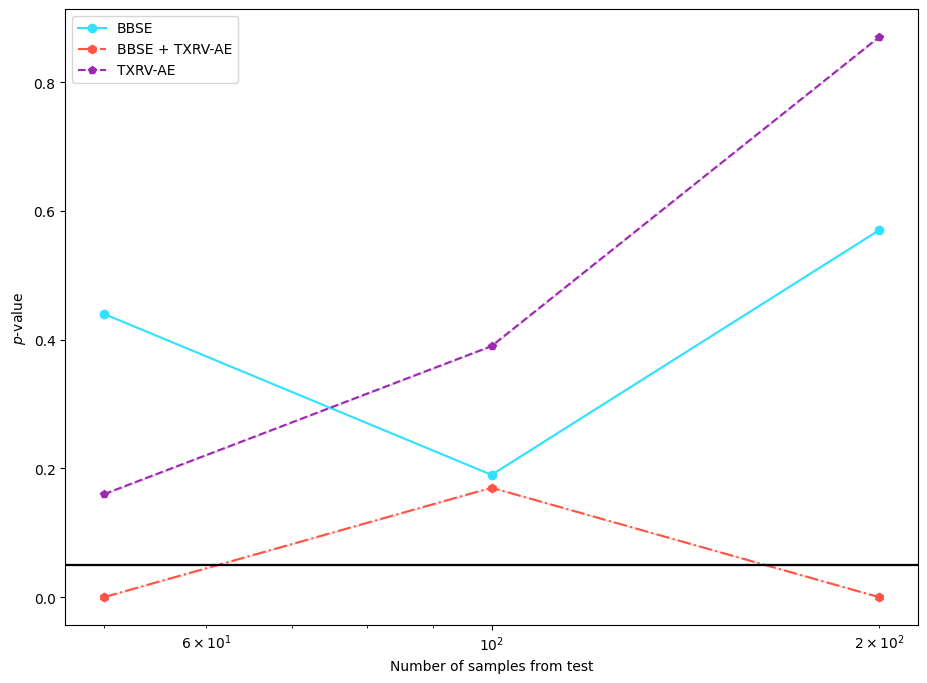

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.85 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.09 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.48 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.36 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.19 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.14 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.14 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.56 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.61 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.84 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.99 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.15 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.73 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.35 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.41 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.80 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.56 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.40 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.94 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.48 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.71 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.00 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.09 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.01 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.06 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.35 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.09 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.18 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.99 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.70 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.31 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.93 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.96 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.01 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.38 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.18 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.11 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.48 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.77 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.58 examples/s]

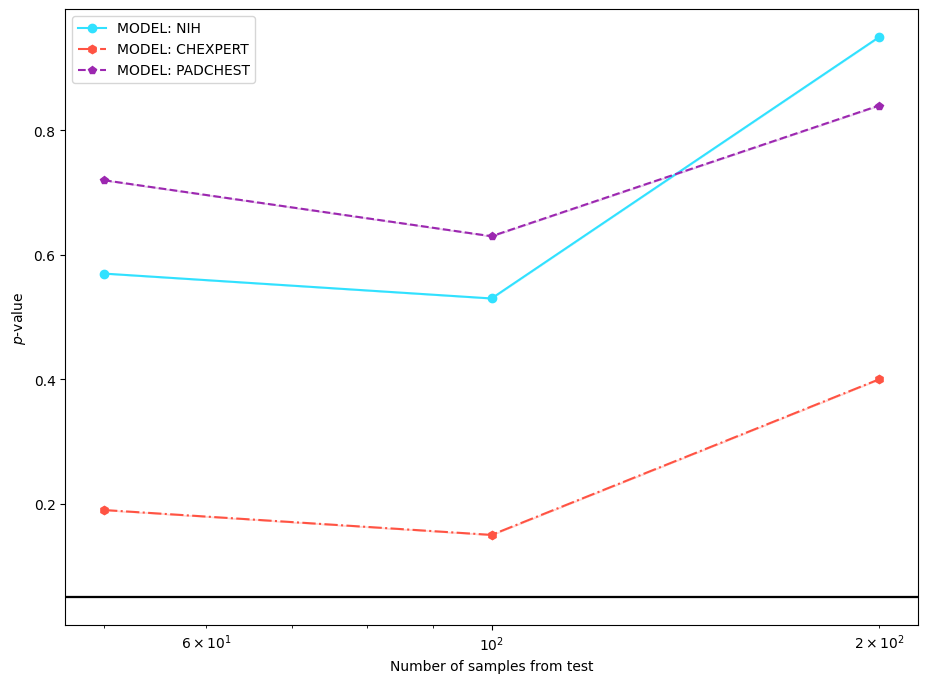

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53325.80 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77721.66 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93013.06 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102394.37 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108851.62 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114912.97 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54374.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80852.65 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94852.45 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104474.02 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110473.31 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114428.61 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.15 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.31 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.50 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.78 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.53 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.70 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.48 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.99 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.48 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.31 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.18 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.78 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53994.95 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77327.55 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90375.82 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97420.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101004.09 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106313.96 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48722.83 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76669.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90293.33 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99419.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 106193.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109852.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.15 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.11 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.55 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.79 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.36 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.90 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.81 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.51 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.95 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.96 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.74 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.55 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.17 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.72 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.04 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.86 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.62 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52788.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77870.87 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87126.66 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99805.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106430.03 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110985.80 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54069.89 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78636.37 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93084.45 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101158.07 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106192.61 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111492.96 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.03 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.42 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.89 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.50 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.51 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.04 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.13 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.54 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.34 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.96 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.78 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53740.61 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77679.63 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91541.54 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99870.77 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104165.82 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107826.36 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52492.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77346.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85742.39 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99919.47 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 105401.15 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109710.31 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.51 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.44 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.18 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.31 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.52 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.34 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.19 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.61 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.12 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.23 examples/s]

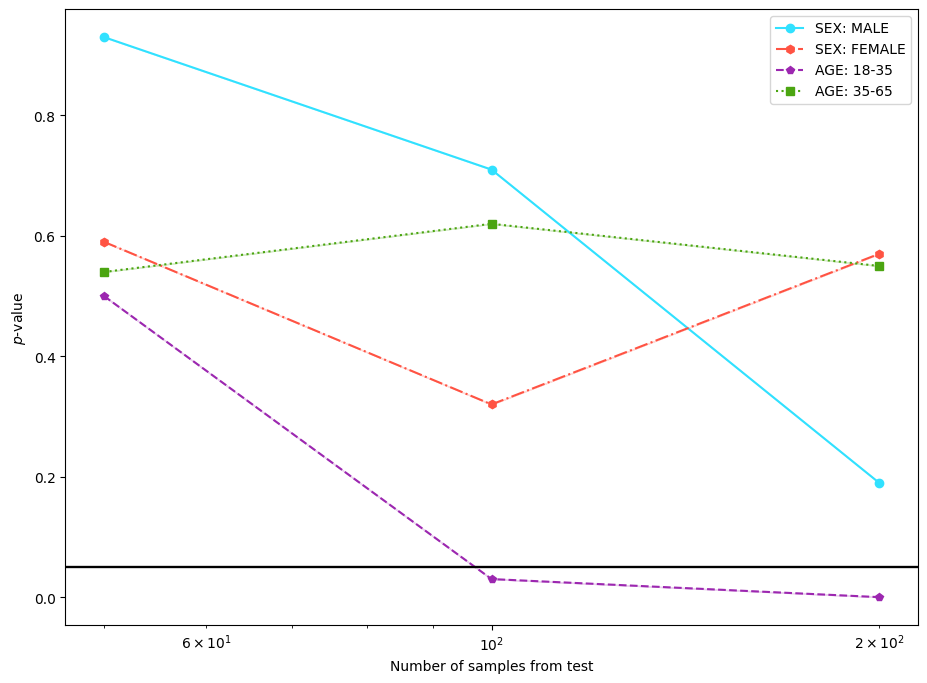

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.32 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.85 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.89 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.24 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.16 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.49 examples/s]

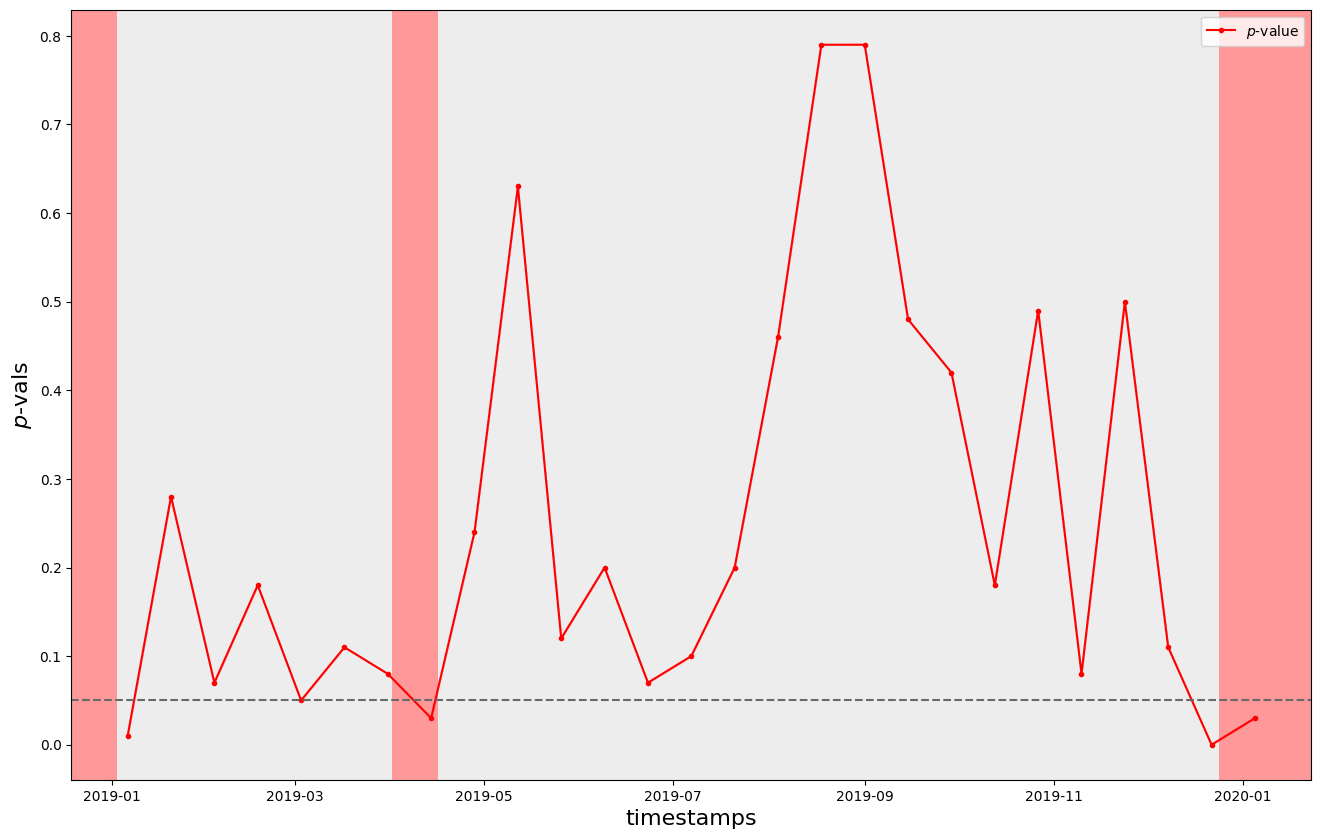

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)